# Random Initialization
Jakub Darul 

Lab4 - K-means

In [1]:
from lab2.img_utils import  load_all,get_X_y,get_points
from lab2.rounding_utils import round_means_and_std_devs
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.pylab as pylab
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import numpy as np
np.seterr('ignore')
np.seterr(divide='ignore')
from typing import Optional,List,Dict,Tuple,Callable

Przygotowałem zaproponowane 5 sposobów inicjalizacji dla k-means:

In [2]:
class Initializer:
    @staticmethod
    def random(point_arr:np.ndarray,k:int,random_state=None)-> np.ndarray:
        min_x1 = np.min(point_arr[:,0])
        max_x1 = np.max(point_arr[:,0])
        x1_delta = max_x1-min_x1
        
        min_x2 = np.min(point_arr[:,1])
        max_x2 = np.max(point_arr[:,1])
        x2_delta = max_x2-min_x2
        
        sample = np.random.random_sample((k,2))
        sample[:,0]= sample[:,0]*x1_delta + min_x1
        sample[:,1]= sample[:,1]*x2_delta + min_x2
        return sample
        
    
    @staticmethod
    def random_partition(point_arr:np.ndarray,k:int,random_state=None)-> np.ndarray:
        init_labels = np.random.randint(0,k,size=(point_arr.shape[0],))
        result = np.zeros((k,2))
        for label in range(k):
            labelled_pts = point_arr[init_labels== label]
            result[label] = labelled_pts.mean(0)
        return result
    
    @staticmethod
    def forgy():
        return "random" #sklearn calls random sample from points `random` method when we call it `forgy` method
    
    @staticmethod
    def kplus():
        return "k-means++"
    
    @staticmethod
    def initializers():
        return {
            "random": Initializer.random,
            "random_parition": Initializer.random_partition,
            "forgy":Initializer.forgy(),
            "k-means++":Initializer.kplus()
        }

**Zad 1.:**
>Naszym celem jest uzyskanie wykresu jakości klastryzacji Q w zależności od numeru iteracji n dla wszystkich powyższych metod inicjalizacji (wszystkie wyniki na jednym wykresie). Jakość Q rozumiemy jako wybraną metrykę jakości (np. Davies-Bouldin index czy Dunn index, może być dowolna rozsądna inna - ale nie Silhouette). Proces k-means jest silnie stochastyczny, więc eksperyment powtarzamy wielokrotnie, a na wykresie pokazujemy średni wynik i jego odchylenie standardowe jako errorbary.

In [3]:
def consecutive_iteration_score(k:int,point_arr:np.ndarray,inits:int,max_iters:int,initializer)-> Tuple[float,float]:
    M = np.zeros((inits,max_iters))

    def initialize():
        if type(initializer) == str:
            return initializer
        else:
            return initializer(point_arr,k) 
        
    
    for init_i in range(inits):
        centroids = None
        
        for iter_i in range(1,max_iters+1):
            kmeans = KMeans(
                n_clusters=k,
                init= initialize() if centroids is None else centroids
                ,n_init=1,
                max_iter=1).fit(point_arr)
            
            
            
            #todo:wont get better check
            M[init_i,iter_i-1]= davies_bouldin_score(point_arr,kmeans.labels_)
            centroids= kmeans.cluster_centers_
            
    means = np.mean(M,axis=0)
    stds = np.std(M,axis=0)
    return means,stds

In [4]:
def present_quality_depending_on_repeat_count(fig,img:np.ndarray,title:str)-> None:
    gs = gridspec.GridSpec(2, 1)
    gs.update(hspace=0.4)
    
    ax= fig.add_subplot(gs[0,0])
    ax.imshow(img)
    ax = fig.add_subplot(gs[1,0])
    pts = get_points(img)
    X,y = get_X_y(pts)
    
    for initializer_name,initializer in Initializer.initializers().items():
        max_iter=40
        inits = 50
        
        iters = [range(1,max_iter+1)]
        means,std_devs = consecutive_iteration_score(9,X,inits,max_iter,initializer)
       
        xdata,ydata,yerr = np.array(iters),means.reshape((1,-1)),std_devs.reshape((1,-1))
        ax.errorbar(xdata, ydata, yerr = yerr, barsabove=True,  fmt='--',label=initializer_name)
    ax.set_title(title)
    ax.set_ylabel("DBI")

    ax.set_xlabel("Iteration count")
    ax.legend(loc='best')
    plt.show()


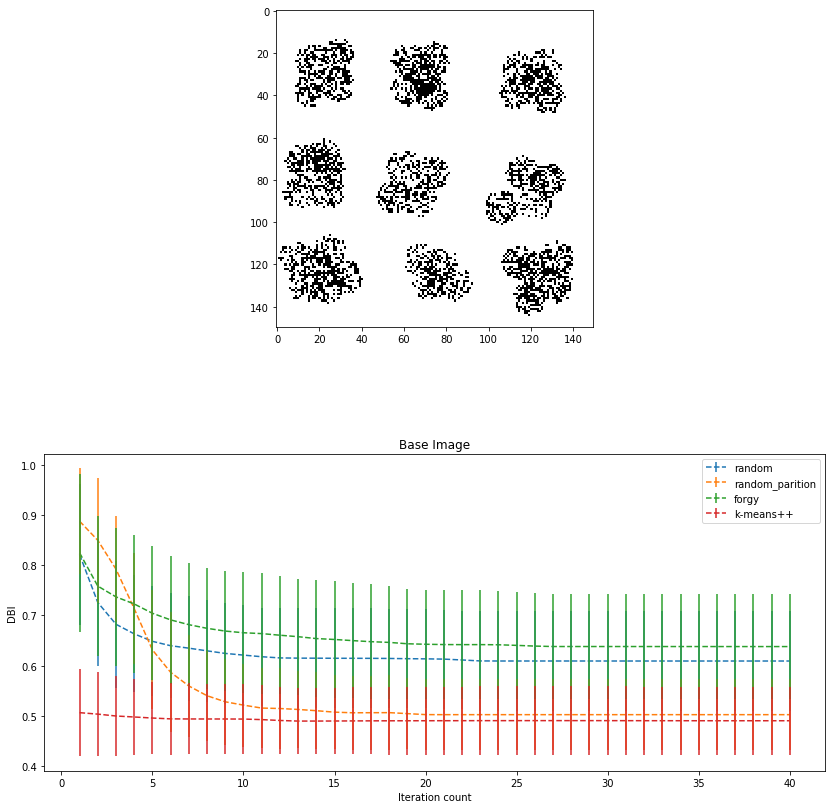

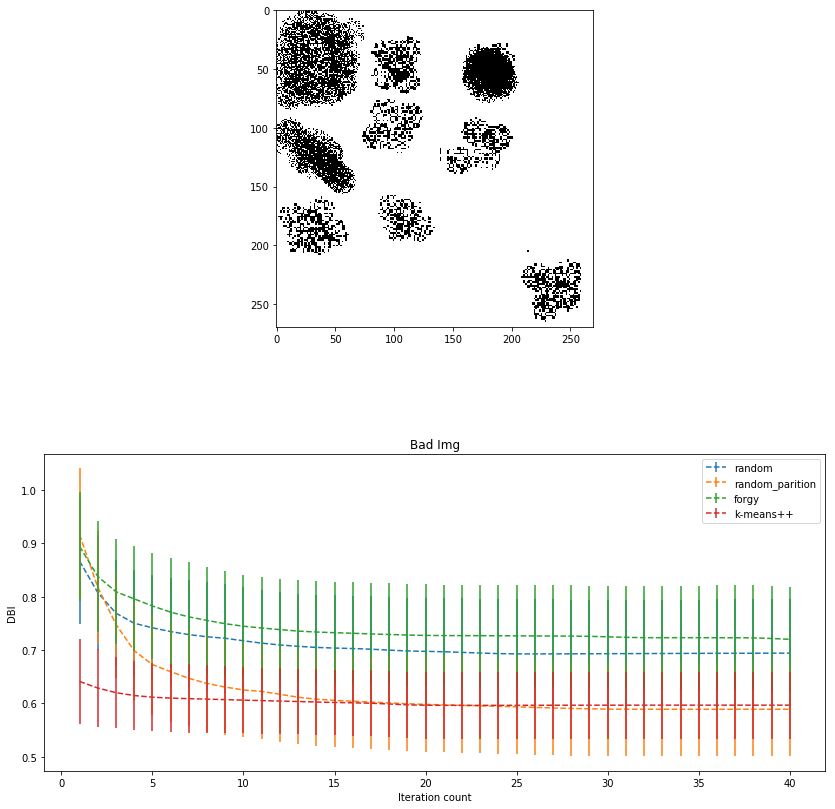

In [5]:
[good_img,bad_img] = load_all(["base.bmp","bad.bmp"])

fig = plt.figure()
fig.set_size_inches(14,14)
present_quality_depending_on_repeat_count(fig,good_img,"Base Image")

fig = plt.figure()
fig.set_size_inches(14,14)
present_quality_depending_on_repeat_count(fig,bad_img,"Bad Img")

Możemy zauważyc, że w ciągu 40 iteracji większość odpaleń k-means najprawdopodobniej zdążyła osiągnąć swoje minima lokalne, ( wyjątek - forgy dla *złego* obrazka). Im niższy index DBI, tym jakośc klastryzacji jest lepsza, dla tego nie dziwi nas, że dla zepsutego obrazka mamy wyższe wskaźniki.

Na wykresach możemy zauwazyć, że jakości inicjalizaji (parami ) k-means++ i random parition, oraz forgy i random są do sobie zbliżone. Widzimy, że używanie pierwszej pary daje lepszą klasteryzację, a k-means ++ zbiega najszybciej.



** Zad 2**
>Finalnie, dla obu zbiorów (oryginalnego i "zepsutego") uruchommy dla różnych k z zakresu od 1 do 20 i porównajmy finalne metryki jakości. Czy na ich podstawie można stwierdzić, że optymalne k to 9 (bo tyle mamy klastrów)?

In [11]:
def get_score_and_iters(initializer, point_arr:np.ndarray,max_iters,k:int) -> float:
    if type(initializer) !=str:
        initializer = initializer(point_arr,k)
    kmeans = KMeans(k,init=initializer,n_init=1,max_iter=max_iters).fit(point_arr)
    return davies_bouldin_score(point_arr,kmeans.labels_),kmeans.n_iter_

In [12]:
def get_scores_mean_stddev(initializer, point_arr:np.ndarray,inits:int ,max_iters:int,k:int=9)-> Optional[Tuple[float,float]]:
    scores =[]
    for _ in range(inits):
        score,iters = get_score_and_iters(initializer,point_arr,300 if max_iters is None else max_iters,k)
        scores.append(score)
    if 0< len(scores):
        scores = np.array(scores)
        mean = scores.mean()
        std = scores.std()
        return mean,std
    else:
        return None

In [13]:
def present_quality_depending_on_k(fig,img:np.ndarray,initializer,title:str)-> None:
    ax = fig.add_subplot(111)
    pts = get_points(img)
    X,y = get_X_y(pts)
    
    ks= [i for i in range(2,20)]
    means = []
    std_devs =[]
    for k in ks:
        
        mean,std_dev = get_scores_mean_stddev(Initializer.kplus(),X,inits=20,max_iters=None,k=k)
        rounded_mean,rounded_std_dev = round_means_and_std_devs(np.array([mean]),np.array([std_dev]))
        means.append(rounded_mean)
        std_devs.append(rounded_std_dev)
       
    xdata,ydata,yerr = ks,means,std_devs
    ax.errorbar(xdata, ydata, yerr = yerr, barsabove=True,  fmt='--')
    ax.set_title(title)
    ax.set_ylabel("DBI")

    ax.set_xlabel("Initialization count")
    plt.show()

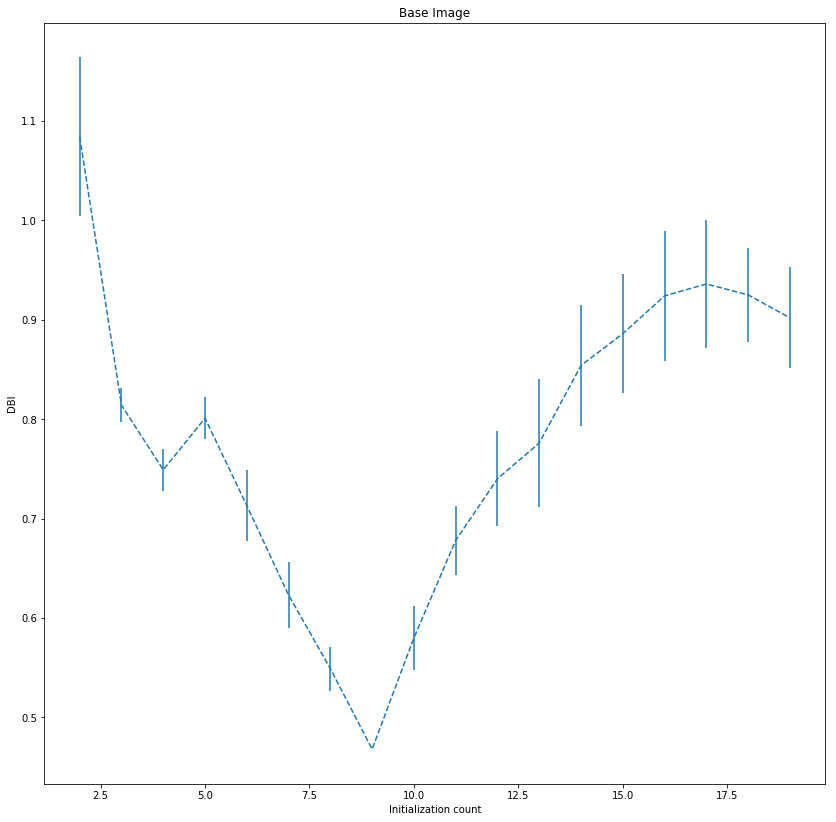

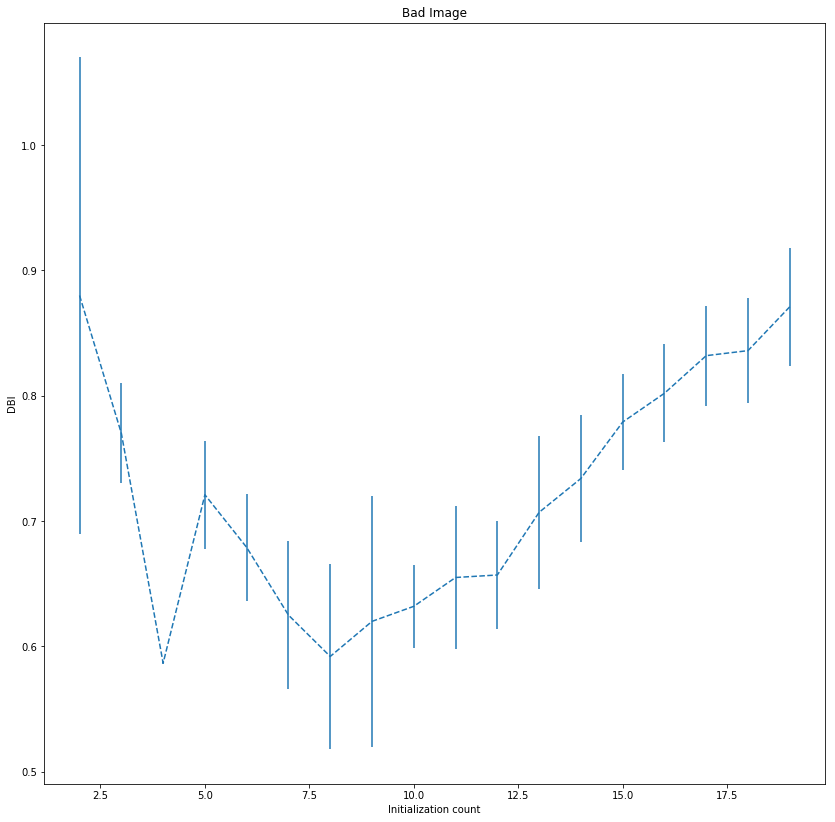

In [14]:
fig = plt.figure()
fig.set_size_inches(14,14)
present_quality_depending_on_k(fig,good_img,Initializer.random_partition,"Base Image")

fig = plt.figure()
fig.set_size_inches(14,14)
present_quality_depending_on_k(fig,bad_img,Initializer.kplus(),"Bad Image")

Możemy zauwazyć, że dla *dobrych* klastrów wyraźnie wskazane jest 9 jako k minimalizujące DBI czego się spodziewaliśmy (9 to liczba naszych klastrów), dla *złych* klastrów nie ma takiej równowaznej odpowiedzi - mamy podobne minima w k= 4 i k= 8.
